In [1]:
# Imports

import sys
sys.path.append("../")
import numpy
import matplotlib
from tensorflow import keras
from classes import ModelWrapper, DataLoader, Cluster, Plotting, lossBCEprojMSE, getTotalNonlinearityResiduum, fitLinePCA

#Interactive matplotlib plots
%matplotlib widget

2024-08-08 08:55:01.267593: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [51]:
# Initialisation

modelAPI = ModelWrapper(keras.models.load_model("./models/3D/M1", compile=False))
data_loader = DataLoader("./data")
noisy = data_loader.getBatch(experimental=True, noisy=True, normalising=True)
noisy_with_E = data_loader.getBatch(experimental=True, noisy=True, normalising=False)
clean = data_loader.getBatch(experimental=True, noisy=False, normalising=True)
names = data_loader.getX17Names()

cmap = matplotlib.pyplot.get_cmap("Greys")
cmap.set_under('cyan')

def upsample(event):
	return numpy.repeat(numpy.repeat(event, 10, axis=0), 10, axis=1)[:100,:120,:200]	# for accurate visualisation

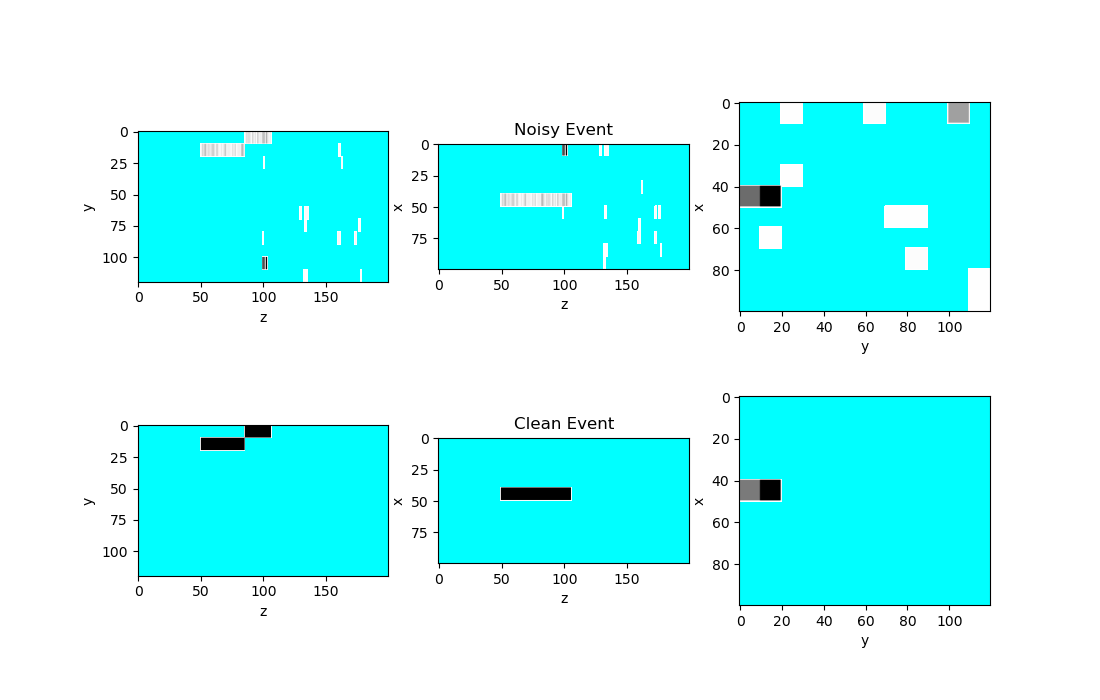

In [50]:
#View generated data

events = data_loader.getBatch(False, True, 0, normalising=False)
clean_events = data_loader.getBatch(False, False, 0, normalising=False)
index = numpy.random.randint(0, events.shape[0])

fig = matplotlib.pyplot.gcf()
matplotlib.pyplot.close(fig)

fig, ax = matplotlib.pyplot.subplots(2,3)
fig.set_size_inches(11, 7)
#fig.tight_layout()
axes_names = [["z","y"],["z","x"],["y", "x"]]

for axis in [0,1,2]:
	ax[0,axis].imshow(numpy.sum( upsample(events[index]),axis), cmap, vmin=1e-5)
	ax[1,axis].imshow(numpy.sum( upsample(clean_events[index]),axis), cmap, vmin=1e-5)
	for j in[0,1]:
		ax[j,axis].set_xlabel(axes_names[axis][0])
		ax[j,axis].set_ylabel(axes_names[axis][1])
ax[0,1].set_title("Noisy Event")
ax[1,1].set_title("Clean Event")
matplotlib.pyplot.show()

In [56]:
# Find threshold

#threshold_data_noisy, threshold_data_clean = noisy[:100], clean[:100]	# Generated datasets could also be used
threshold_data_noisy, threshold_data_clean = data_loader.getBatch(False, True, 0, True)[:1000], data_loader.getBatch(False, False, 0, True)[:1000]	# Subset of measured data could also be used
threshold_data_clean = numpy.where(threshold_data_clean > 0, 1, 0)
reconstructions = modelAPI.evaluateBatch(threshold_data_noisy) * threshold_data_noisy

def distance(target, prediction):
	'''TPs = numpy.sum( numpy.where(target==1, prediction, 0), axis=(1,2,3) )
	FPs = numpy.sum( numpy.where(target==0, prediction, 0), axis=(1,2,3) )
	TNs = numpy.sum( numpy.where(target==0, 1-prediction, 0), axis=(1,2,3) )
	FNs = numpy.sum( numpy.where(target==1, 1-prediction, 0), axis=(1,2,3) )
	Ys = TPs / (TPs + FNs) + TNs / (TNs + FPs) - 1
	return -numpy.mean(Ys)'''	# Youden's Index instead of L1 distance
	return numpy.sum(numpy.abs(target-prediction))

steps = 8
num_points = 21
low, high = 0, 1
for i in range(steps):
	print(i+1, "/", steps)
	samples = numpy.linspace(low, high, num_points)
	distances = []
	minimising_threshold, min_value = None, None
	for sample_threshold in samples:
		distances.append( distance(threshold_data_clean, numpy.where(reconstructions > sample_threshold, 1, 0)) )
		if min_value == None or distances[-1] < min_value:
			minimising_threshold, min_value = sample_threshold, distances[-1]
	if minimising_threshold == samples[0]:
		low, high = samples[0], samples[1]
	elif minimising_threshold == samples[-1]:
		low, high = samples[-2], samples[-1]
	else:
		for k in range(num_points):
			if minimising_threshold == samples[k]:
				low, high = samples[k-1], samples[k+1]
				break
	print(low, high, distances)
threshold = (low+high)/2
modelAPI.threshold = threshold
print(threshold)


32/32 [==============================] - 6s 194ms/step
1 / 8
0.0 0.1 [72093, 9135, 20022, 30671, 38386, 43579, 46744, 48706, 49967, 50701, 51098, 51346, 51474, 51563, 51601, 51625, 51636, 51650, 51654, 51648, 51644]
2 / 8
0.0 0.01 [72093, 3868, 4071, 4460, 4948, 5465, 6068, 6692, 7420, 8264, 9135, 10109, 11058, 12080, 13199, 14272, 15425, 16515, 17697, 18879, 20022]
3 / 8
0.0055 0.006500000000000001 [72093, 4796, 4378, 4182, 4067, 3973, 3917, 3884, 3879, 3859, 3868, 3858, 3857, 3887, 3901, 3945, 3966, 3982, 4007, 4047, 4071]
4 / 8
0.0059 0.006 [3858, 3856, 3856, 3853, 3857, 3857, 3857, 3856, 3853, 3852, 3857, 3870, 3871, 3873, 3867, 3869, 3870, 3874, 3880, 3884, 3887]
5 / 8
0.005955 0.005965 [3853, 3856, 3856, 3857, 3856, 3856, 3856, 3856, 3855, 3853, 3852, 3852, 3850, 3854, 3854, 3855, 3856, 3857, 3857, 3857, 3857]
6 / 8
0.005959 0.00596 [3852, 3852, 3851, 3851, 3851, 3851, 3851, 3851, 3851, 3850, 3850, 3850, 3850, 3850, 3851, 3853, 3853, 3853, 3853, 3854, 3854]
7 / 8
0.0059592 0.0059

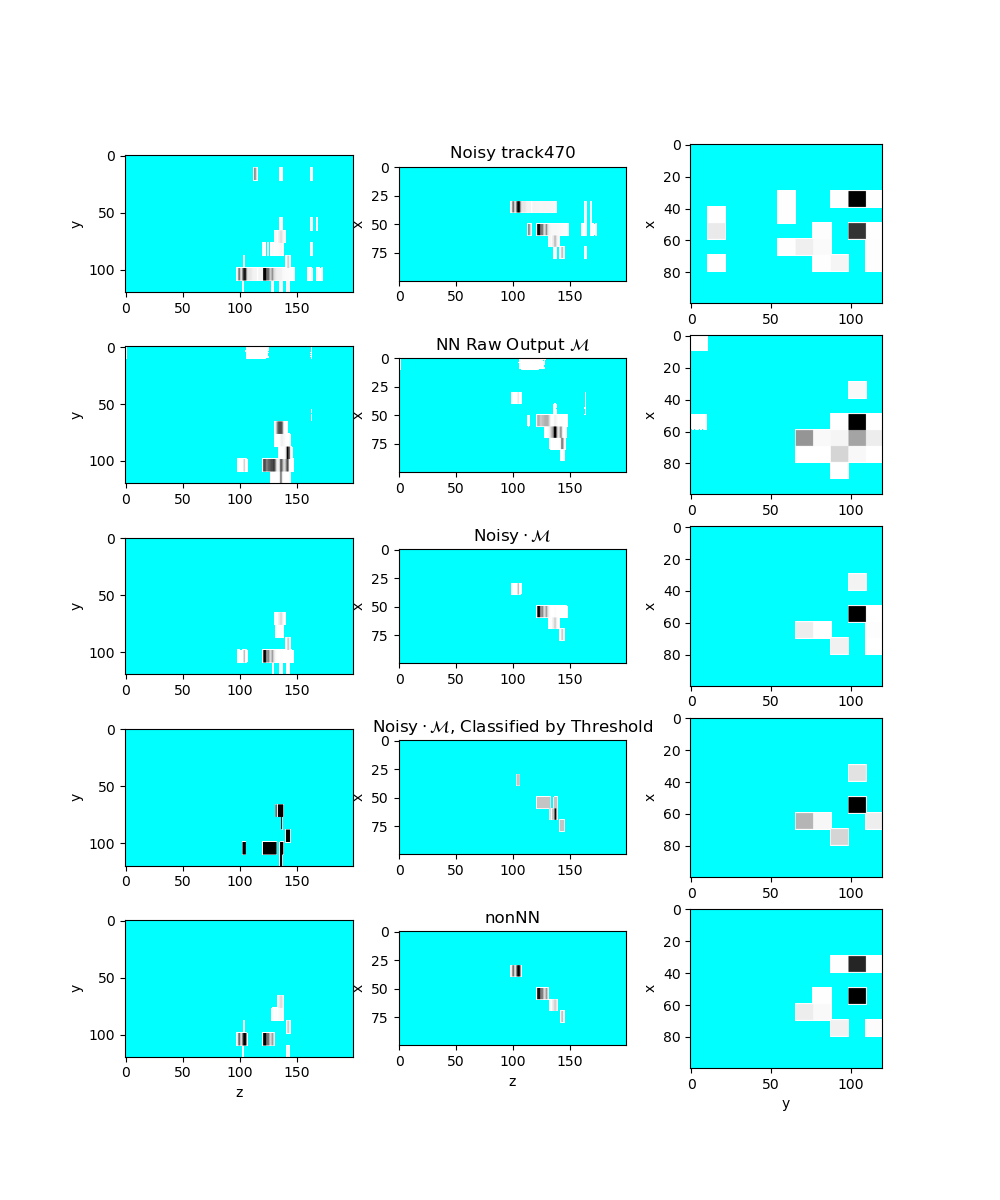

In [85]:
# View and compare reconstructions

#modelAPI.threshold = 0.005959224999999999	# Found in previous step

#index = numpy.random.randint(0, 642)
index = numpy.random.choice(DataLoader.nice_track_indices)
noisy_event = noisy[index]
nonNN_reconstruction = clean[index]
NN_raw_reconstruction = modelAPI.evaluateSingleEvent(noisy_event)
NN_multiply_reconstruction = NN_raw_reconstruction * noisy_event
NN_classification = modelAPI.classify(NN_multiply_reconstruction) 

def upsample(event):
	return numpy.repeat(numpy.repeat( numpy.copy(event) , 10, axis=0), 11, axis=1)[:100,:120,:200]

fig = matplotlib.pyplot.gcf()
matplotlib.pyplot.close(fig)

fig, ax = matplotlib.pyplot.subplots(5,3)
fig.set_size_inches(10, 12)
#fig.tight_layout()
proj_type = ["zy","zx","yx"]

for axis in [0,1,2]:
	ax[0,axis].imshow(numpy.sum(upsample( noisy_event ), axis), cmap, vmin=numpy.min([1e-6, numpy.max(noisy_event)])/2)
	ax[1,axis].imshow(numpy.sum(upsample( NN_raw_reconstruction ), axis), cmap, vmin=numpy.min([1e-6, numpy.max(NN_raw_reconstruction)])/2)
	ax[2,axis].imshow(numpy.sum(upsample( NN_multiply_reconstruction ), axis), cmap, vmin=numpy.min([1e-6, numpy.max(NN_multiply_reconstruction)])/2)
	ax[3,axis].imshow(numpy.sum(upsample( NN_classification ), axis), cmap, vmin=numpy.min([1e-6, numpy.max(NN_classification)])/2)
	ax[4,axis].imshow(numpy.sum(upsample( nonNN_reconstruction ), axis), cmap, vmin=numpy.min([1e-6, numpy.max(nonNN_reconstruction)])/2)

	for j in range(5):
		ax[j,axis].set_ylabel(proj_type[axis][1])
	ax[-1,axis].set_xlabel(proj_type[axis][0])

ax[0,1].set_title("Noisy " + names[index])
ax[1,1].set_title(r"NN Raw Output $\mathcal{M}$")
ax[2,1].set_title(r"$\text{Noisy} \cdot \mathcal{M}$")
ax[3,1].set_title(r"$\text{Noisy} \cdot \mathcal{M}$, Classified by Threshold")
ax[4,1].set_title("nonNN")
matplotlib.pyplot.show()